<a href="https://colab.research.google.com/github/thaisrezendeb/ufes_machineLearning/blob/main/L2_Exercicio6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**6) Para as bases de dados Spiral e Jain (disponíveis em
http://cs.joensuu.fi/sipu/datasets/), agrupe os dados em 3 e 2 grupos,
respectivamente, usando kmeans e clusterização hierárquica. Avalie o
resultado com a métrica de acurácia com o seguinte procedimento: para cada cluster verifique qual foi a classe predominante, amostras pertencentes a outras classes estão no grupo errado. Faça os experimentos com a distância Euclidiana. Gere gráficos com os grupos formados pelo kmeans e clusterização hierárquica. Comente os resultados. Lembre-se de não usar o atributo da classe para agrupar os dados.**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

uri_spiral = "http://cs.joensuu.fi/sipu/datasets/spiral.txt"
uri_jain = "http://cs.joensuu.fi/sipu/datasets/jain.txt"

spiral = pd.read_csv(uri_spiral, sep="\t", header=None)
jain = pd.read_csv(uri_jain, sep="\t", header=None)

In [ ]:
#Algoritmo Kmeans
#Recebe:
# - Dados de dimensão D para calcular o cluster (sem coluna de classificação)
# - Número de clusters desejados 
# - Semente para seleção das amostras iniciais (padrão = nenhuma)
# - Número de iterações para o algoritmo (padrão = 10)
#Retorna:
# - Array contendo classificação de cada amostra em seu cluster
def cluster_kmeans(data, k, semente=None, iter=10):
  count = 0
  continua = True
  y_kmeans = np.zeros((data.shape[0]))
  centroides = np.zeros((k, data.shape[1]))

  #definição inicial dos centróides
  for n in range(0, k):
    #Seleção aleatória de amostras para iniciar centróide
    np.random.seed(semente)
    centroides[n] = data.iloc[np.random.randint(0, high=data.shape[0]-1)]
  
  while continua:
    count = count + 1

    #Análise das amostras para cada centróide
    for i,row in data.iterrows():
      #Distância para primeiro centroide
      dist = 0
      for t in range(0, data.shape[1]):
        dist = dist + np.power(row[t]-centroides[0][t],2)
      
      dist = np.sqrt(dist)
      min_dist = dist
      y_kmeans[i] = 1
      for j in range(1, k):
        dist = 0
        for t in range(0, data.shape[1]):
          dist = dist + np.power(row[t]-centroides[j][t],2) 
        
        dist = np.sqrt(dist)
        
        if dist < min_dist:
          min_dist = dist
          y_kmeans[i] = j+1

    #Redefinição dos centroides
    for n in range(0, k):       
      centroides[n] = data.iloc[np.where(y_kmeans[:] == n+1)].mean()

    #Critério de parada pelo número de iterações
    if iter > 0:
      if count > iter:
        continua = False

  return y_kmeans

In [ ]:
X_spiral = spiral.drop(2, axis=1)
y_spiral = cluster_kmeans(X_spiral, k=3)

X_jain = jain.drop(2, axis=1)
y_jain = cluster_kmeans(X_jain, k=2)

In [ ]:
#Cálculo da acurácia para Kmeans
acuracia = 0
for i in spiral[2].unique():
  unique, counts = np.unique(y_spiral[spiral[spiral[2] == i].index.values], \
                             return_counts=True)
  acuracia = acuracia + max(counts)/counts.sum()
  
acuracia = acuracia/spiral[2].unique().size

print("Acurácia Kmeans base 'spiral' = {:.2f}%".format(acuracia*100))

acuracia = 0
for i in jain[2].unique():
  unique, counts = np.unique(y_jain[jain[jain[2] == i].index.values], \
                             return_counts=True)
  acuracia = acuracia + max(counts)/counts.sum()
  
acuracia = acuracia/jain[2].unique().size

print("Acurácia Kmeans base 'jain' = {:.2f}%".format(acuracia*100))

Acurácia Kmeans base 'spiral' = 36.21%
Acurácia Kmeans base 'jain' = 84.45%


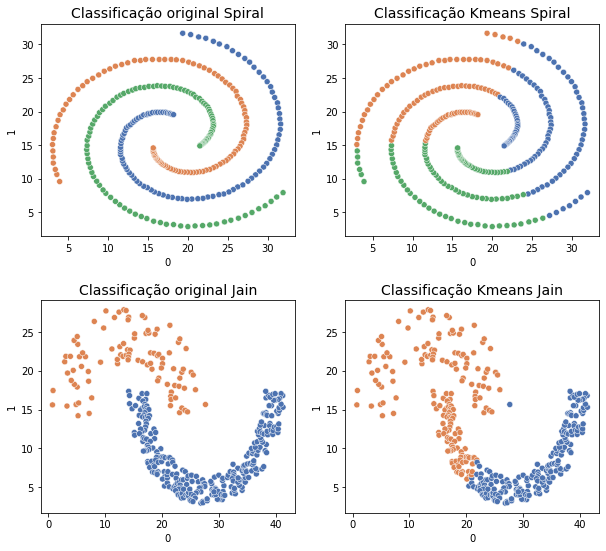

In [ ]:
fig, axes = plt.subplots(2, 2)
axes[0][0].set_title("Classificação original Spiral", fontsize=14)
sns.scatterplot(ax=axes[0][0], data=spiral, x=0, y=1, hue=2, legend=None, palette="deep")
axes[0][1].set_title("Classificação Kmeans Spiral", fontsize=14)
sns.scatterplot(ax=axes[0][1], data=spiral, x=0, y=1, hue=y_spiral, legend=None, palette="deep")
axes[1][0].set_title("Classificação original Jain", fontsize=14)
sns.scatterplot(ax=axes[1][0], data=jain, x=0, y=1, hue=2, legend=None, palette="deep")
axes[1][1].set_title("Classificação Kmeans Jain", fontsize=14)
sns.scatterplot(ax=axes[1][1], data=jain, x=0, y=1, hue=y_jain, legend=None, palette="deep")
fig.set_figwidth(10)
fig.set_figheight(9)
fig.subplots_adjust(hspace=0.3)

In [ ]:
#Algoritmo AGNES (Agglomerative Nesting)
#Recebe:
# - Dados de dimensão D para calcular o cluster (sem coluna de classificação)
# - Número de clusters desejados 
#Retorna:
# - Array contendo classificação de cada amostra em seu cluster
def cluster_agnes(data, n_cluster=2):
  y_agnes = data.index.values #Cada amostra inicia em seu próprio cluster
  matriz_dist = np.zeros((data.shape[0],data.shape[0]))
  
  #Cálculo da matriz de distâncias
  for i,row1 in data.iterrows():
    for j,row2 in data.iterrows():
      if i == j:
        continue

      dist = 0
      for k in range(0, data.shape[1]):
        dist = dist + np.power(row1[k]-row2[k], 2)

      matriz_dist[i][j] = np.sqrt(dist)
  
  #União em clusters
  continua = True
  while continua:
    #Agrupamento pela média das distâncias entre dois clusters
    labels = np.unique(y_agnes)
    for n in labels:
      min_dist = 99999999999
      min_cluster = n
      for m in labels:
        if m == n:
          continue
        
        #Calcula distância média entre cluster m e cluster n
        idx_x = np.where(y_agnes==n)[0]
        idx_y = np.where(y_agnes==m)[0]

        if len(idx_x) > 0 and len(idx_y) > 0:
          dist = 0
          for i in idx_x:
            for j in idx_y:
              dist = dist + matriz_dist[i][j]
          
          dist = dist / (len(idx_x) * len(idx_y))

          if dist < min_dist:
            min_dist = dist
            min_cluster = m

      if min_cluster != n:
        y_agnes = np.where(y_agnes==min_cluster, n, y_agnes)

      #Critério de parada = número de clusters desejados
      if np.unique(y_agnes).size <= n_cluster:
        continua = False
        break

  return y_agnes

In [ ]:
X_spiral = spiral.drop(2, axis=1)
y_spiral = cluster_agnes(X_spiral, n_cluster=3)

X_jain = jain.drop(2, axis=1)
y_jain = cluster_agnes(X_jain)

In [ ]:
#Cálculo da acurácia para AGNES
acuracia = 0
for i in spiral[2].unique():
  unique, counts = np.unique(y_spiral[spiral[spiral[2] == i].index.values], \
                             return_counts=True)
  acuracia = acuracia + max(counts)/counts.sum()
  
acuracia = acuracia/spiral[2].unique().size

print("Acurácia AGNES base 'spiral' = {:.2f}%".format(acuracia*100))

acuracia = 0
for i in jain[2].unique():
  unique, counts = np.unique(y_jain[jain[jain[2] == i].index.values], \
                             return_counts=True)
  acuracia = acuracia + max(counts)/counts.sum()
  
acuracia = acuracia/jain[2].unique().size

print("Acurácia AGNES base 'jain' = {:.2f}%".format(acuracia*100))

Acurácia AGNES base 'spiral' = 37.81%
Acurácia AGNES base 'jain' = 95.29%


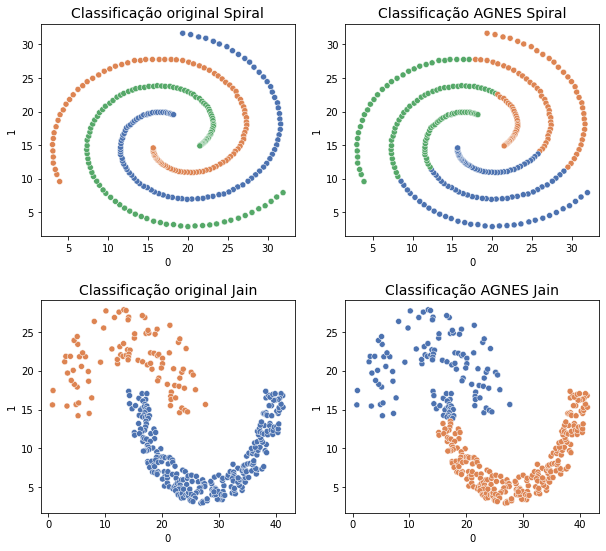

In [ ]:
fig, axes = plt.subplots(2, 2)
axes[0][0].set_title("Classificação original Spiral", fontsize=14)
sns.scatterplot(ax=axes[0][0], data=spiral, x=0, y=1, hue=2, legend=None, palette="deep")
axes[0][1].set_title("Classificação AGNES Spiral", fontsize=14)
sns.scatterplot(ax=axes[0][1], data=spiral, x=0, y=1, hue=y_spiral, legend=None, palette="deep")
axes[1][0].set_title("Classificação original Jain", fontsize=14)
sns.scatterplot(ax=axes[1][0], data=jain, x=0, y=1, hue=2, legend=None, palette="deep")
axes[1][1].set_title("Classificação AGNES Jain", fontsize=14)
sns.scatterplot(ax=axes[1][1], data=jain, x=0, y=1, hue=y_jain, legend=None, palette="deep")
fig.set_figwidth(10)
fig.set_figheight(9)
fig.subplots_adjust(hspace=0.3)

In [ ]:
#Algoritmo de teste
#from sklearn.cluster import KMeans

#X = spiral.drop(2, axis=1)

#kmeans = KMeans(n_clusters=3, random_state=0).fit(X)
#class_pre = kmeans.predict(X)
#sns.scatterplot(data=spiral, x=0, y=1, hue=class_pre, legend=None, palette="deep")

In [ ]:
#from sklearn.cluster import AgglomerativeClustering

#X = spiral.drop(2, axis=1)

#class_pre = AgglomerativeClustering(n_clusters=3).fit_predict(X)
#sns.scatterplot(data=spiral, x=0, y=1, hue=class_pre, legend=None, palette="deep")

In [ ]:
#from sklearn.cluster import DBSCAN

#X = jain.drop(2, axis=1)

#class_pre = DBSCAN(eps=2.5, min_samples=20).fit_predict(X)
#sns.scatterplot(data=jain, x=0, y=1, hue=class_pre, legend=None, palette="deep")